In [1]:
import torch
import matplotlib.pyplot as plt
import os
from datetime import datetime
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

In [2]:
directory = "IMF_ENVs/2nd_test"
fileList = []

for fileName in os.listdir(directory):
    filePath = os.path.join(directory, fileName)
    fileList.append(filePath)
    
def extract_date(string):
    return string.split("_")[-2]

def date_key(string):
    date_str = extract_date(string)
    if date_str:
        return datetime.strptime(date_str, '%Y.%m.%d.%H.%M.%S')

sorted_file_list = sorted(fileList, key=date_key)

R = 20000
N = 20480

BPFO = 236
BPFO2 = 2 * BPFO
BPFO3 = 3 * BPFO
BPFO4 = 4 * BPFO

def BPFO_index(N, R, BPFO):
    BPFO_idx = []
    
    for k in range(N):
        f = (k / N) * R

        if (f > BPFO-1 and f < BPFO+1): # all frequencies in the bin
            BPFO_idx.append(k)
        
    return BPFO_idx

BPFO_idx = BPFO_index(N, R, BPFO)
BPFO2_idx = BPFO_index(N, R, BPFO2)
BPFO3_idx = BPFO_index(N, R, BPFO3)
BPFO4_idx = BPFO_index(N, R, BPFO4)

In [3]:
bearing1_BPFOs = [] # values of the fft of the env of the imf at frequencies of the  BPFOs, [BPFO, BPFO2. BPFO3, BPFO4]
bearing2_BPFOs = [] # values of the fft of the env of the imf at freq BPFO * 2
bearing3_BPFOs = [] # values of the fft of the env of the imf at freq BPFO * 2
bearing4_BPFOs = [] # values of the fft of the env of the imf at freq BPFO * 2

bearing1_fft_env_imf1_sorted = []
bearing2_fft_env_imf1_sorted = []
bearing3_fft_env_imf1_sorted = []
bearing4_fft_env_imf1_sorted = []

bearing1_BPFO2_A = []
bearing1_BPFO3_A = []
bearing1_BPFO4_A = []


# Per file in sorted order, fft of the first imf's envelope is calulated
for filePath in sorted_file_list:
    tensor = torch.load(filePath, map_location=torch.device('cpu'))
    env_imf1 = tensor[0].cpu()

    if (filePath[-4] == str(1)):
        fft_env_imf1 = torch.fft.fft(env_imf1)
        bearing1_fft_env_imf1_sorted.append(fft_env_imf1)

        BPFOs = []
        BPFOs.append([fft_env_imf1[i] for i in BPFO2_idx])  
        BPFOs.append([fft_env_imf1[i] for i in BPFO3_idx])  
        BPFOs.append([fft_env_imf1[i] for i in BPFO4_idx])
        bearing1_BPFOs.append(BPFOs)

        bearing1_BPFO2_A.append(fft_env_imf1[BPFO2_idx[0]])
        bearing1_BPFO3_A.append(fft_env_imf1[BPFO3_idx[0]])
        bearing1_BPFO4_A.append(fft_env_imf1[BPFO4_idx[0]])
    
    elif (filePath[-4] == str(2)):  
        fft_env_imf1 = torch.fft.fft(env_imf1)
        bearing2_fft_env_imf1_sorted.append(fft_env_imf1)

        BPFOs = []
        # BPFOs.append([fft_env_imf1[i] for i in BPFO_idx])  
        BPFOs.append([fft_env_imf1[i] for i in BPFO2_idx])  
        BPFOs.append([fft_env_imf1[i] for i in BPFO3_idx])  
        BPFOs.append([fft_env_imf1[i] for i in BPFO4_idx])
        bearing2_BPFOs.append(BPFOs)

    elif (filePath[-4] == str(3)):
        fft_env_imf1 = torch.fft.fft(env_imf1)
        bearing3_fft_env_imf1_sorted.append(fft_env_imf1)

        BPFOs = []
        # BPFOs.append([fft_env_imf1[i] for i in BPFO_idx])  
        BPFOs.append([fft_env_imf1[i] for i in BPFO2_idx])  
        BPFOs.append([fft_env_imf1[i] for i in BPFO3_idx])  
        BPFOs.append([fft_env_imf1[i] for i in BPFO4_idx])
        bearing3_BPFOs.append(BPFOs)

    else:
        fft_env_imf1 = torch.fft.fft(env_imf1)
        bearing4_fft_env_imf1_sorted.append(fft_env_imf1)
        
        BPFOs = []
        # BPFOs.append([fft_env_imf1[i] for i in BPFO_idx])  
        BPFOs.append([fft_env_imf1[i] for i in BPFO2_idx])  
        BPFOs.append([fft_env_imf1[i] for i in BPFO3_idx])  
        BPFOs.append([fft_env_imf1[i] for i in BPFO4_idx])
        bearing4_BPFOs.append(BPFOs)

In [4]:
def amplitudes(ffts_at_BPFO_freq):

    Ans_per_BPFO = []

    for BPFO in ffts_at_BPFO_freq:

        An_s = []
        
        for bins in BPFO:
            An_temp = []

            absolutes_bins = [abs(bin) for bin in bins]

            An_s.append(max(absolutes_bins).item())

        Ans_per_BPFO.append(An_s)

    return Ans_per_BPFO

def amplitudes2(ffts_at_BPFO_freq):
    ffts_at_BPFO_freq = np.array(ffts_at_BPFO_freq)
    peaks, _ = find_peaks(np.abs(ffts_at_BPFO_freq))
    
    amplitudes = np.abs(ffts_at_BPFO_freq[peaks])

    return amplitudes, peaks

ampl_BPFO2, peak_idx_BPFO2 = amplitudes2(bearing1_BPFO2_A)
ampl_BPFO3, peak_idx_BPFO3 = amplitudes2(bearing1_BPFO3_A)
ampl_BPFO4, peak_idx_BPFO4 = amplitudes2(bearing1_BPFO4_A)

window_size = 4

# Pad the array to handle the edges
padded_ampl_BPFO2 = np.pad(ampl_BPFO2, pad_width=window_size, mode='edge')
padded_ampl_BPFO3 = np.pad(ampl_BPFO3, pad_width=window_size, mode='edge')
padded_ampl_BPFO4 = np.pad(ampl_BPFO4, pad_width=window_size, mode='edge')

An_BPFO2 = np.array([np.max(padded_ampl_BPFO2[i:i + 2 * window_size + 1]) for i in range(len(ampl_BPFO2))])
An_BPFO2_norm = (An_BPFO2 - min(An_BPFO2)) / (max(An_BPFO2) - min(An_BPFO2))

An_BPFO3 = np.array([np.max(padded_ampl_BPFO3[i:i + 2 * window_size + 1]) for i in range(len(ampl_BPFO3))])
An_BPFO3_norm = (An_BPFO3 - min(An_BPFO3)) / (max(An_BPFO3) - min(An_BPFO3))

An_BPFO4 = np.array([np.max(padded_ampl_BPFO4[i:i + 2 * window_size + 1]) for i in range(len(ampl_BPFO4))])
An_BPFO4_norm = (An_BPFO4 - min(An_BPFO4)) / (max(An_BPFO4) - min(An_BPFO4))

full_indices = np.arange(0, len(bearing1_BPFO2_A))

# interpolate so that everything remains in the right amount of samples
interpolated_An_BPFO2_norm = np.interp(full_indices, peak_idx_BPFO2, An_BPFO2_norm)
interpolated_An_BPFO3_norm = np.interp(full_indices, peak_idx_BPFO3, An_BPFO3_norm)
interpolated_An_BPFO4_norm = np.interp(full_indices, peak_idx_BPFO4, An_BPFO4_norm)

interpolated_An_BPFOs_norm = np.column_stack((interpolated_An_BPFO2_norm, interpolated_An_BPFO3_norm, interpolated_An_BPFO4_norm))

# np.save("interpolated_An_BPFOs_norm_2nd_test", interpolated_An_BPFOs_norm)

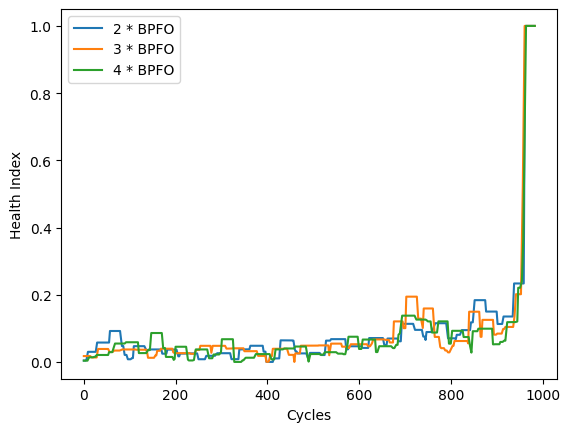

In [5]:
plt.plot(interpolated_An_BPFOs_norm, label=["2 * BPFO", "3 * BPFO","4 * BPFO"])
plt.xlabel("Cycles")
plt.ylabel("Health Index")
plt.legend()
# plt.savefig("trainingdatabeforeSAE.pdf")
plt.show()

In [6]:
bearing1 = amplitudes(bearing1_BPFOs)
bearing2 = amplitudes(bearing2_BPFOs)
bearing3 = amplitudes(bearing3_BPFOs)
bearing4 = amplitudes(bearing4_BPFOs)

def normalize_min_max(bearing):
    scaler = MinMaxScaler()
    scaler.fit(bearing)
    scaled_data = scaler.transform(bearing)

    return scaled_data

scaled_bearing1 = normalize_min_max(bearing1)
scaled_bearing2 = normalize_min_max(bearing2)
scaled_bearing3 = normalize_min_max(bearing3)
scaled_bearing4 = normalize_min_max(bearing4)

# np.save("normalized_bearing1_2nd_test", scaled_bearing1)

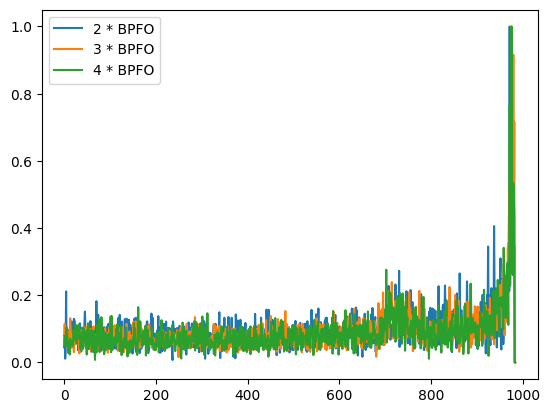

In [7]:
plt.plot(scaled_bearing1, label=["2 * BPFO", "3 * BPFO", "4 * BPFO"])
# plt.plot(scaled_bearing2, label=["2 * BPFO", "3 * BPFO", "4 * BPFO"])
# plt.plot(scaled_bearing3, label=["2 * BPFO", "3 * BPFO", "4 * BPFO"])
# plt.plot(scaled_bearing4, label=["2 * BPFO", "3 * BPFO", "4 * BPFO"])

plt.legend()
plt.show()